In [1]:
import numpy as np
import csv
from matplotlib import cm
import matplotlib.pyplot as plt
import copy

# Fig. 3a

### load data

In [2]:
sfacs = [1, 1.2, 1.6]; nsfacs = len(sfacs)
nbootstrap = 100
fit_orders = [1, 'exp']; nfits = len(fit_orders)
nqubits=127

# load bootstrap, unmitigated data
data_bootstrap_unmit = {}
with open("data/fig3a_bootstrap_unmit.txt", 'r') as f:
    for d in csv.reader(f):
        data = np.array([float(d_) for d_ in d[1:]]).reshape((nqubits, nsfacs, nbootstrap))
        data_bootstrap_unmit[float(d[0])] = data
        
# load bootstrap, mitigated data
data_bootstrap_mit = {}
with open("data/fig3a_bootstrap_mit.txt", 'r') as f:
    for d in csv.reader(f):
        data = np.array([float(d_) for d_ in d[1:]]).reshape((nqubits, nbootstrap, nfits, 2)) # the last 2 is value/fit uncertainty
        data_bootstrap_mit[float(d[0])] = data
        
# load experimental, unmitigated data
data_exp_unmit = {}
with open("data/fig3a_experiment_unmit.txt", 'r') as f:
    for d in csv.reader(f):
        data = np.array([float(d_) for d_ in d[1:]]).reshape((nqubits, nsfacs))
        data_exp_unmit[float(d[0])] = data
        
# load experimental, unmitigated data
data_exp_mit = {}
with open("data/fig3a_experiment_mit.txt", 'r') as f:
    for d in csv.reader(f):
        data = np.array([float(d_) for d_ in d[1:]]).reshape((nqubits, nfits, 2)) # the last 2 is value/fit uncertainty
        data_exp_mit[float(d[0])] = data

### process data

In [3]:
percentile_=68.2
criteria=0.5

percentile=50 + percentile_/2.0 #percentile_ + (100-percentile_)/2.0
idx_sfac1 = sfacs.index(1)

In [4]:
import copy

x_angles=[]
y_unmit=[]
y_unmit_err=[[], []]
y_mit=[]
y_mit_err=[[], []]

y_unmit_exp=[]
y_mit_exp=[]

idx_sfac1 = sfacs.index(1)

for angle, unmit in data_bootstrap_unmit.items():
    mit = data_bootstrap_mit[angle]
    mit_exp = data_exp_mit[angle]
    y_unmit_exp.append(np.mean(data_exp_unmit[angle][:,idx_sfac1]))
    x_angles.append(angle)
    
    # unmitigated bootstrap results
    unmit_c1 = unmit[:,idx_sfac1,:]
    unmit_c1_mean = np.mean(unmit_c1, axis=0)
    a = np.median(unmit_c1_mean)
    b = np.percentile(unmit_c1_mean, 100-percentile)
    c = np.percentile(unmit_c1_mean, percentile)
    y_unmit.append(a)
    y_unmit_err[0].append(a-b)
    y_unmit_err[1].append(c-a)
    
    # mitigated bootstrap results
    mit_best=copy.copy(unmit[:,idx_sfac1,:])

    for n in range(nbootstrap):
        for k in range(nfits):
            tmp = np.where(mit[:,n,k,1] < criteria)[0]
            mit_best[tmp,n] = mit[tmp,n,k,0]

    mit_mean = np.mean(mit_best, axis=0)
    a = np.median(mit_mean)
    b = np.percentile(mit_mean, 100-percentile)
    c = np.percentile(mit_mean, percentile)
    y_mit.append(a)
    y_mit_err[0].append(a-b)
    y_mit_err[1].append(c-a)
    
    tmp = copy.copy(data_exp_unmit[angle][:,idx_sfac1])
    
    for k in range(nfits):
        mask_ = np.where( mit_exp[:, k, 1] < criteria )[0]
        tmp[mask_] = mit_exp[mask_, k, 0]
    y_mit_exp.append(np.mean(tmp))

In [5]:
# sort by x axis
idx = np.argsort(x_angles)
x_angles = np.array(x_angles)[idx]
y_unmit=np.array(y_unmit)[idx]
y_unmit_err=[np.array(vals)[idx] for vals in y_unmit_err]
y_mit=np.array(y_mit)[idx]
y_mit_err=[np.array(vals)[idx] for vals in y_mit_err]
y_unmit_exp=np.array(y_unmit_exp)[idx]
y_mit_exp=np.array(y_mit_exp)[idx]

### load simulation data

In [6]:
x, y = [], []
with open("data/fig3a_exact.txt", 'r') as f:
    for d in csv.reader(f):
        x.append(float(d[0]))
        y.append(float(d[1]))
exact_sim = [x, y]

x, y = [], []
with open("data/fig3a_MPS.txt", 'r') as f:
    for d in csv.reader(f):
        x.append(float(d[0]))
        y.append(float(d[1]))
MPS_sim = [x, y]

x, y = [], []
with open("data/fig3a_isoTNS.txt", 'r') as f:
    for d in csv.reader(f):
        x.append(float(d[0]))
        y.append(float(d[1]))
isoTNS_sim = [x, y]

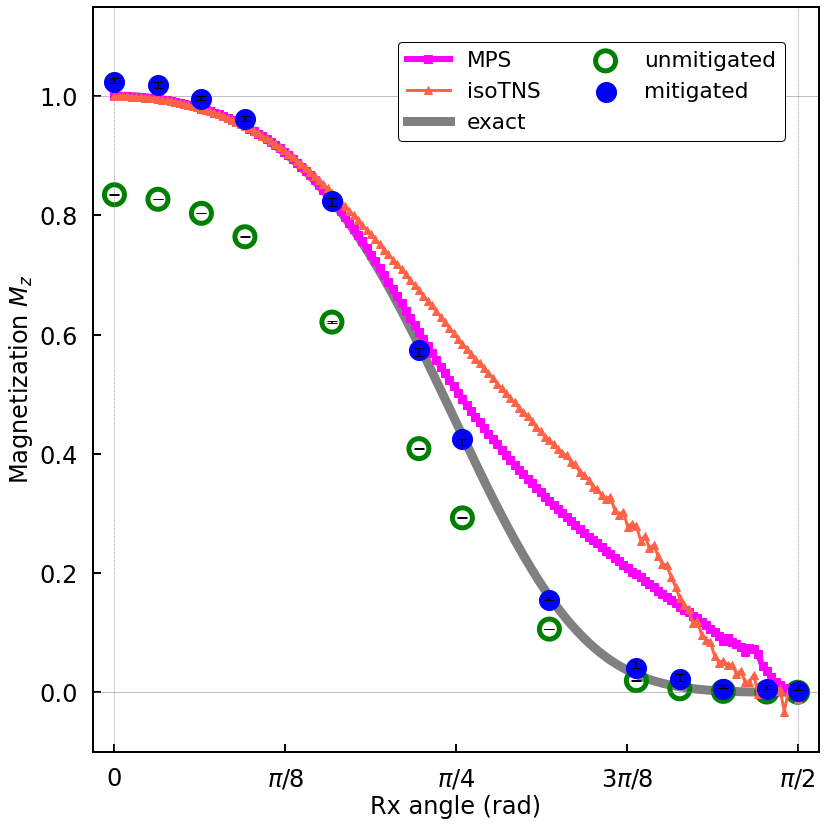

In [7]:
fontsize_global=24
plt.rcParams['font.size'] = fontsize_global
plt.rcParams['axes.linewidth'] = 2

ylim = [-0.1, 1.15]
xfactor = 1
alpha=1.0
markersize_factor=4.0
markersize=2*markersize_factor
markersize_sim=100*markersize_factor
markersize_ideal=1000*markersize_factor
linewidth=6

ylabel = 'Magnetization $M_z$'

fit_colors=list(cm.Reds(np.linspace(0.3, 0.9, 3))) + ['b'] + ['g']

ncol=1; nrow=1;
fig, axes = plt.subplots(nrow,ncol, figsize=(12*ncol,12*nrow))

kwargs_c1_exp={'color': 'g', 'label': 'unmitigated', 's': markersize_sim, 'facecolors': 'none', 'linewidths': 5.0}
kwargs_exp={'color': 'b', 'label': 'mitigated', 's': markersize_sim}

ax = axes

ax.axvline(np.pi/2, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(0, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(1, color='grey', linestyle='-', linewidth=0.5)
ax.axhline(0, color='grey', linestyle='-', linewidth=0.5)

         

# tensor network method
x, y = MPS_sim
marker='s'; color='magenta'; edgecolor='none'
linewidth_=linewidth
label_='MPS'
idx = np.argsort(x)
x = np.array(x)[idx]
y = np.array(y)[idx]
ax.plot(x, y, color=color, label=label_, marker=marker, markersize=markersize, linewidth=linewidth_)

x, y = isoTNS_sim
marker='^'; color='tomato'; edgecolor='none'
linewidth_=linewidth-3
label_='isoTNS'
idx = np.argsort(x)
x = np.array(x)[idx]
y = np.array(y)[idx]
ax.plot(x, y, color=color, label=label_, marker=marker, markersize=markersize, linewidth=linewidth_)

# exact simulation results
x, y = exact_sim
linewidth_=linewidth+3
ax.plot(x, y, color='grey', marker='.', label='exact', linewidth=linewidth_, zorder=1)

#experiment - unmitigated
ax.errorbar(x_angles, y_unmit, yerr=y_unmit_err, c='k', fmt='', linestyle='', ecolor='black', barsabove=True, zorder=3, solid_capstyle='projecting', capsize=5)
ax.scatter(x_angles, y_unmit_exp, **kwargs_c1_exp, zorder=2)

# mitigated
ax.errorbar(x_angles, y_mit, yerr=y_mit_err, c='k', fmt='', linestyle='', ecolor='black', barsabove=True, zorder=5, solid_capstyle='projecting', capsize=5)
ax.scatter(x_angles, y_mit_exp, **kwargs_exp, zorder=4)
                
ax.set_xlim(np.array([np.min(x_angles)-0.05, np.max(x_angles) + 0.05])*xfactor)
ax.set_ylim(ylim)  

xticks = np.array([0, 0.125, 0.25, 0.375, 0.5])*np.pi
xticks_label = ['0', '$\pi$/8', '$\pi$/4', '$3\pi$/8', '$\pi$/2']
ax.tick_params(axis="both", direction="in", length=8, width=2, pad=15)
#ax.set_xticks(xticks, xticks_label)
ax.set_xticks(xticks);ax.set_xticklabels(xticks_label)
ax.set_xlabel('Rx angle (rad)')
ax.set_ylabel(ylabel)
#ax.set_title(ylabel, fontsize=fontsize_global)

leg = ax.legend(frameon=True, fontsize=fontsize_global*0.9, ncol=2, loc=(0.42,0.82))
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(1)
leg.get_frame().set_alpha(1)

plt.tight_layout()
plt.show()

In [8]:
import analysis_utils
import importlib
importlib.reload(analysis_utils)

<module 'analysis_utils' from 'c:\\Users\\Monit Sharma\\Dropbox\\My PC (LAPTOP-K0D5CN56)\\Downloads\\ibm\\Evidence-for-the-utility-of-quantum-computing-before-fault-tolerance-main\\analysis_utils.py'>

In [9]:
coupling_map=[
    [2, 1], [33, 39], [59, 60], [66, 67], [72, 81], [118, 119], [21, 20], [26, 25], [13, 12], [31, 32], [70, 74], [122, 123], [97, 96], [57, 56], [63, 64], [107, 108], [103, 104], [46, 45], [28, 35], [7, 6], [79, 78], [5, 4], [109, 114], [62, 61], [58, 71], [37, 52], [76, 77], [0, 14], [36, 51], [106, 105], [73, 85], [88, 87], [68, 55], [116, 115], [94, 95], [100, 110], [17, 30], [92, 102], [50, 49], [83, 84], [48, 47], [98, 99], [8, 9], [121, 120], [23, 24], [44, 43], [22, 15], [53, 41],
    [53, 60], [123, 124], [21, 22], [11, 12], [67, 68], [2, 3], [66, 65], [122, 121], [110, 118], [6, 5], [94, 90], [28, 29], [14, 18], [62, 63], [111, 104], [100, 99], [45, 44], [4, 15], [20, 19], [57, 58], [77, 71], [76, 75], [26, 27], [16, 8], [35, 47], [31, 30], [48, 49], [69, 70], [125, 126], [89, 74], [80, 79], [116, 117], [114, 113], [10, 9], [106, 93], [101, 102], [92, 83], [98, 91], [82, 81], [54, 64], [96, 109], [85, 84], [87, 86], [108, 112], [34, 24], [42, 43], [40, 41], [39, 38],
    [10, 11], [54, 45], [111, 122], [64, 65], [60, 61], [103, 102], [72, 62], [4, 3], [33, 20], [58, 59], [26, 16], [28, 27], [8, 7], [104, 105], [66, 73], [87, 93], [85, 86], [55, 49], [68, 69], [89, 88], [80, 81], [117, 118], [101, 100], [114, 115], [96, 95], [29, 30], [106, 107], [83, 82], [91, 79], [0, 1], [56, 52], [90, 75], [126, 112], [36, 32], [46, 47], [77, 78], [97, 98], [17, 12], [119, 120], [22, 23], [24, 25], [43, 34], [42, 41], [40, 39], [37, 38], [125, 124], [50, 51], [18, 19],
]

In [10]:
# load experimental, unmitigated data
data_exp_unmit = {}
with open("data/fig3a_experiment_unmit.txt", 'r') as f:
    for d in csv.reader(f):
        data = np.array([float(d_) for d_ in d[1:]]).reshape((nqubits, nsfacs))
        data_exp_unmit[float(d[0])] = data
        
# load experimental, unmitigated data
data_exp_mit = {}
with open("data/fig3a_experiment_mit.txt", 'r') as f:
    for d in csv.reader(f):
        data = np.array([float(d_) for d_ in d[1:]]).reshape((nqubits, nfits, 2)) # the last 2 is value/fit uncertainty
        data_exp_mit[float(d[0])] = data
        
# load corresponding pauli string (1th qubit --- 127th qubit order)
paulis = []
with open("data/fig3a_paulis.txt", 'r') as f:
    for d in csv.reader(f):
        paulis.append(d)
# it is only one line of data so take 0th in the list
paulis = [p.replace(' ', '') for p in paulis[0]] # make sure to remove whitespace padding

In [11]:
## fresh compute quantities to make sure
import copy

target_angle=0.2
idx_sfac1 = sfacs.index(1)

for angle, vals in data_exp_unmit.items():
    if angle != target_angle:
        continue
    
    y_unmit_exp_indiv = np.array(vals)[:, idx_sfac1]
    tmp = copy.copy(np.array(vals)[:, idx_sfac1])
    mit_exp = np.array(data_exp_mit[angle])
    for k in range(nfits):
        mask_ = np.where( mit_exp[:, k, 1] < criteria )[0]
        tmp[mask_] = mit_exp[mask_, k, 0]
    y_mit_exp_indiv = tmp

In [12]:
# reindexing based on pauli string
idx = [p.replace(' ', '').index('Z') for p in paulis] # you can do this because it is weight-1 observable
Z_c1 = y_unmit_exp_indiv[idx]
Z_mit = y_mit_exp_indiv[idx]

In [13]:
colormap='viridis'
colormap='plasma'
vmin = np.min([np.min(Z_c1), np.min(Z_mit)])*0.95
vmax = 1.05
vmin = 0.6
dv = vmax-vmin
color_c1 = [eval(f'cm.{colormap}({val})') for val in (Z_c1-vmin)/dv]
color_mit = [eval(f'cm.{colormap}({val})') for val in (Z_mit-vmin)/dv]
print(f'min: {vmin} - max: {vmax}')

min: 0.6 - max: 1.05


c:\Users\Monit Sharma\Dropbox\My PC (LAPTOP-K0D5CN56)\Downloads\ibm\Evidence-for-the-utility-of-quantum-computing-before-fault-tolerance-main\analysis_utils.py:258: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


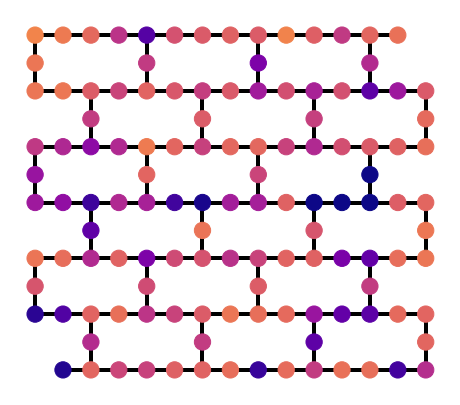

In [14]:
qubit_lists = [[q] for q in list(range(nqubits))]
analysis_utils.plot_qubits(qubit_lists, nqubits, coupling_map, colors=color_c1)

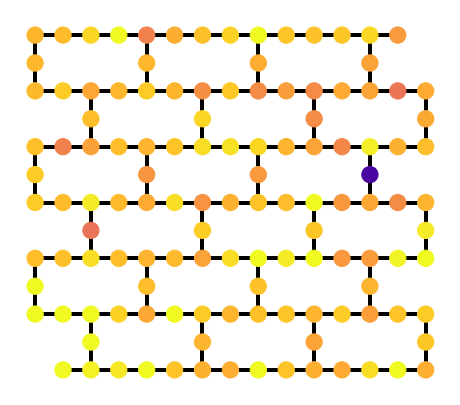

In [15]:
qubit_lists = [[q] for q in list(range(nqubits))]
analysis_utils.plot_qubits(qubit_lists, nqubits, coupling_map, colors=color_mit)

In [16]:
import pickle
filename = 'data/exactMagnetization_steps5_qubits127_reducedTrue_HFalse.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)
Z_exact = data['Szs'][20] # list of 127 <Sz> values, one for each qubit.
Z_exact = np.array([np.real(val) for val in np.array(Z_exact)])

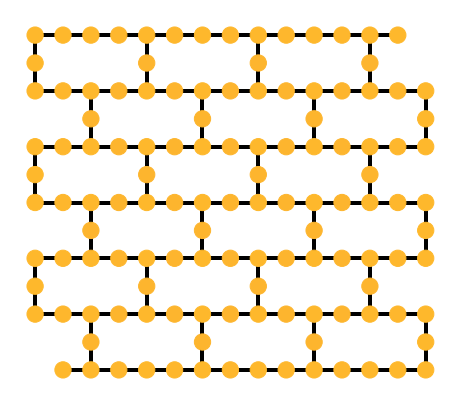

In [17]:
color_exact = [eval(f'cm.{colormap}({val})') for val in (Z_exact-vmin)/dv]

qubit_lists = [[q] for q in list(range(nqubits))]
analysis_utils.plot_qubits(qubit_lists, nqubits, coupling_map, colors=color_exact)